##Calculated Spearman Coefficient to measures the strength and direction of association between two ranked variables.



In [0]:
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

## Mounting the drive

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/machine_learning_assign/data')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
!pip install pyprind

# Importing Libraries

In [4]:
import pandas as pd
import keras
from keras.layers import Dense
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


import numpy as np
from string import punctuation
import pyprind
from collections import Counter
#from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Loading Captions and Video Memorability from the two files

In [0]:
# loading labels and captions
def read_caps(fname):
    """Load the captions into a dataframe"""
    vn = []
    cap = []
    df = pd.DataFrame();
    with open(fname) as f:
        for line in f:
            pairs = line.split()
            vn.append(pairs[0])
            cap.append(pairs[1])
        df['video']=vn
        df['caption']=cap
    return df


# load the captions
cap_path = './dev-set_video-captions.txt'
df_captions=read_caps(cap_path)

# load the ground truth values
label_path = './'
labels=pd.read_csv(label_path+'dev-set_ground-truth.csv')

##Joining the dataframes.

In [6]:
df = df_captions.merge(labels,on=["video"],how="inner")
df

,video,caption,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,blonde-woman-is-massaged-tilt-down,0.924,34,0.846,13
1,video4.webm,roulette-table-spinning-with-ball-in-closeup-shot,0.923,33,0.667,12
2,video6.webm,khr-gangsters,0.863,33,0.700,10
3,video8.webm,medical-helicopter-hovers-at-airport,0.922,33,0.818,11
4,video10.webm,couple-relaxing-on-picnic-crane-shot,0.950,34,0.900,10
5,video12.webm,passing-by-older-man-reading,0.783,74,0.750,12
6,video13.webm,christmas-village-and-national-christmas-tree,0.861,40,0.700,10
7,video16.webm,unhappy-friends-looking-for-something-interest...,0.834,33,0.857,14
8,video17.webm,hoover-dam-tourists-traffic,0.777,43,1.000,11
9,video18.webm,happy-girl-stretching-and-relaxing-on-the-station,0.863,33,1.000,9




# Preprocessing Data

## Remove punctuation

In [7]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [0]:
#function to remove punctuation
def remove_punct(text):
  text_nopunct="".join([char for char in text if char not in string.punctuation])  #it will discard all punctuation
  return text_nopunct

In [9]:
df['body_text_clean']=df['caption'].apply(lambda x: remove_punct(x))
df.head()

,video,caption,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations,body_text_clean
0,video3.webm,blonde-woman-is-massaged-tilt-down,0.924,34,0.846,13,blondewomanismassagedtiltdown
1,video4.webm,roulette-table-spinning-with-ball-in-closeup-shot,0.923,33,0.667,12,roulettetablespinningwithballincloseupshot
2,video6.webm,khr-gangsters,0.863,33,0.700,10,khrgangsters
3,video8.webm,medical-helicopter-hovers-at-airport,0.922,33,0.818,11,medicalhelicopterhoversatairport
4,video10.webm,couple-relaxing-on-picnic-crane-shot,0.950,34,0.900,10,couplerelaxingonpicniccraneshot


##Tokenization

In [10]:
import re

#function to tokenise

def tokenize(text):
  tokens=re.split('\W+',text)
  return tokens
df['tokenized_body']=df['caption'].apply(lambda x: tokenize(x.lower()))
df.head()


,video,caption,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations,body_text_clean,tokenized_body
0,video3.webm,blonde-woman-is-massaged-tilt-down,0.924,34,0.846,13,blondewomanismassagedtiltdown,"[blonde, woman, is, massaged, tilt, down]"
1,video4.webm,roulette-table-spinning-with-ball-in-closeup-shot,0.923,33,0.667,12,roulettetablespinningwithballincloseupshot,"[roulette, table, spinning, with, ball, in, cl..."
2,video6.webm,khr-gangsters,0.863,33,0.700,10,khrgangsters,"[khr, gangsters]"
3,video8.webm,medical-helicopter-hovers-at-airport,0.922,33,0.818,11,medicalhelicopterhoversatairport,"[medical, helicopter, hovers, at, airport]"
4,video10.webm,couple-relaxing-on-picnic-crane-shot,0.950,34,0.900,10,couplerelaxingonpicniccraneshot,"[couple, relaxing, on, picnic, crane, shot]"


#Vectorizing Data: Bag-Of-Words

##Approach 1

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect=CountVectorizer(min_df=1, stop_words='english') # used to remove stopwords

In [12]:
X_counts=count_vect.fit_transform(df['caption'])
print(X_counts.shape)

(6000, 5019)


In [0]:
X_counts=count_vect.fit_transform(df['caption'])

In [14]:
X_counts_seq=X_counts.toarray()
X_counts_seq

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [15]:
print(X_counts_seq[0])

[0 0 0 ... 0 0 0]


####Since we are getting higher Spearman Correlation with CountVectorizer compared to TFIDF, therefore we are going ahead with Approach 1

#Vectorizing Data: TF-IDF

##Approach 2 : Gives less Spearman's corelation compare to Bag of Words

In [0]:
#tfidf=TfidfVectorizer(min_df=1, stop_words='english')

In [0]:
#X_TFID=tfidf.fit_transform(df['caption'])

In [0]:
#X_seq=X_TFIDF.toarray()
#X_seq

In [0]:
#print(X_seq[0])

#### Spearman Correlation  obtained by using Approach 2 was 0.334

#Model

In [0]:
Y=df[['short-term_memorability','long-term_memorability']].values  #targets
X=X_counts_seq #input

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42) 

In [38]:
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('Y_train', Y_train.shape)
print('Y_test', Y_test.shape)

X_train (4800, 5019)
X_test (1200, 5019)
Y_train (4800, 2)
Y_test (1200, 2)


In [39]:
n_cols = X_train.shape[1]
n_cols

5019

In [0]:
from keras import layers
from keras.layers import Dropout
# Setting up the model using Sequential model
model = Sequential()
# Add the first layer
model.add(Dense(50, activation='relu', input_shape=(n_cols,)))
# Add the second layer
model.add(layers.Dropout(0.6)) #Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training; helps prevent overfitting.
model.add(Dense(32, activation='relu'))
# Add the third layer
model.add(Dense(32, activation='relu'))

# Add the output layer
model.add(Dense(2))

In [0]:
# Compiling the model
model.compile(optimizer='rmsprop', loss = 'mean_squared_error')

In [42]:
# Verifying that model contains information from compiling
print("Loss function: " + model.loss)

Loss function: mean_squared_error


In [43]:
# Fitting the model
history = model.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test))

Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 1s 294us/step - loss: 0.1059 - val_loss: 0.0143
Epoch 2/20
4800/4800 [==============================] - 1s 251us/step - loss: 0.0146 - val_loss: 0.0136
Epoch 3/20
4800/4800 [==============================] - 1s 261us/step - loss: 0.0129 - val_loss: 0.0136
Epoch 4/20
4800/4800 [==============================] - 1s 263us/step - loss: 0.0122 - val_loss: 0.0132
Epoch 5/20
4800/4800 [==============================] - 1s 239us/step - loss: 0.0119 - val_loss: 0.0135
Epoch 6/20
4800/4800 [==============================] - 1s 242us/step - loss: 0.0115 - val_loss: 0.0133
Epoch 7/20
4800/4800 [==============================] - 1s 241us/step - loss: 0.0110 - val_loss: 0.0139
Epoch 8/20
4800/4800 [==============================] - 1s 244us/step - loss: 0.0106 - val_loss: 0.0137
Epoch 9/20
4800/4800 [==============================] - 1s 242us/step - loss: 0.0102 - val_loss: 0.0140
Epoch 10/20
4800

###Visualising the validation and training loss

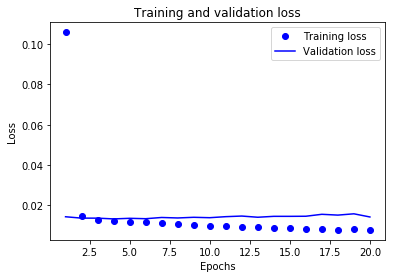

In [44]:
#Visualising the loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [45]:
predictions = model.predict(X_test)
print(predictions)
Get_score(predictions, Y_test) # Calculating Spearman scores which is best if the value is above 0.300

[[0.90141785 0.7640934 ]
 [0.9274813  0.8700167 ]
 [0.87864554 0.79655594]
 ...
 [0.90906763 0.8621563 ]
 [0.887656   0.79150265]
 [0.8871319  0.76261395]]
The Spearman's correlation coefficient is: 0.439
The Spearman's correlation coefficient is: 0.194


In [46]:
predictions

array([[0.90141785, 0.7640934 ],
       [0.9274813 , 0.8700167 ],
       [0.87864554, 0.79655594],
       ...,
       [0.90906763, 0.8621563 ],
       [0.887656  , 0.79150265],
       [0.8871319 , 0.76261395]], dtype=float32)

In [47]:
predictions.min(axis=0)

array([0.7190095, 0.5016094], dtype=float32)

In [48]:
predictions.max(axis=0)

array([0.98198855, 0.9764454 ], dtype=float32)

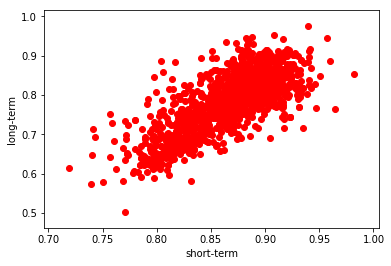

In [49]:
plt.figure()
plt.scatter(predictions[:,0],predictions[:,1],marker='o',c='r')
plt.xlabel('short-term')
plt.ylabel('long-term')
plt.savefig('Prediction_captions.eps')

In [0]:
import pandas as pd
prediction = pd.DataFrame(predictions, columns=['Short_term_score','Long_term_score']).to_csv('./predictions.csv')


In [0]:
model.save('./final_model_memory.h5')  # creates a HDF5 file 'final_model_memory.h5'